# ARIMA in Python

D-590 Spring 2022

Adapted from Jason Brownlee. 2021. Time Series Forecasting.

- ARIMA model: the parameters used and assumptions made by the model
- Fitting an ARIMA model to data and use it to make forecasts
- Configuring the ARIMA model on your time series problem

**ARIMA(p,d,q)**

- p: The number of lag observations included in the model, also called the lag order
- d: The number of times that the raw observations are differenced, also called the degree
of differencing
- q: The size of the moving average window, also called the order of moving average

In [20]:
import warnings
warnings.filterwarnings('ignore')
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from math import sqrt

The shampoo dataset describes the monthly number of sales of shampoo over a 3 year period.
The unitsare a sales count and there are 36 observations. The original dataset is credited to Makridakis,
Wheelwright and Hyndman (1998)

Month
1-01    266.0
1-02    145.9
1-03    183.1
1-04    119.3
1-05    180.3
Name: Sales, dtype: float64


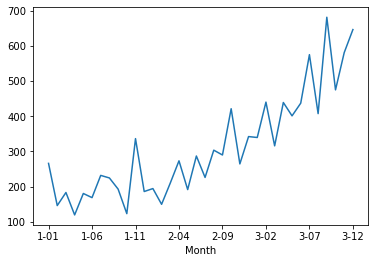

In [5]:
series = read_csv('shampoo-sales.csv', header=0, index_col=0, parse_dates=True,
squeeze=True)
print(series.head())
series.plot()
pyplot.show()

Month
1981-01    266.0
1981-02    145.9
1981-03    183.1
1981-04    119.3
1981-05    180.3
Freq: M, Name: Sales, dtype: float64


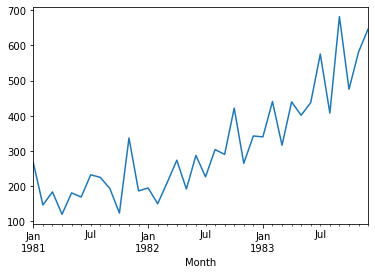

In [13]:
# load dataset
def parser(x):
    return datetime.strptime('198'+x, '%Y-%m')

series = read_csv('shampoo-sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)
# summarize first few rows
series.index = series.index.to_period('M')
print(series.head())
# line plot
series.plot()
pyplot.show()

> the Shampoo Sales dataset has a clear trend. The time series is not stationary and will require differencing to make it stationary, at least a difference order of 1.

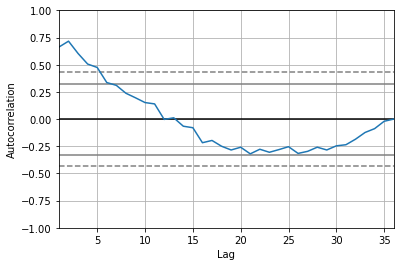

In [11]:
autocorrelation_plot(series)
pyplot.show()

> there is a positive correlation with the first 10-to-12 lags that is perhaps significant for the  first 5 lags. A good starting point for the AR parameter of the model may be 5.

## ARIMA Function

Let's  fit an ARIMA(5,1,0) model:  the lag value of 5 for autoregression, a difference order of 1 to make the time series stationary, and a moving average model of 0.

In [14]:
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -198.485
Date:                Sun, 06 Mar 2022   AIC                            408.969
Time:                        13:44:54   BIC                            418.301
Sample:                    01-31-1981   HQIC                           412.191
                         - 12-31-1983                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9014      0.247     -3.647      0.000      -1.386      -0.417
ar.L2         -0.2284      0.268     -0.851      0.395      -0.754       0.298
ar.L3          0.0747      0.291      0.256      0.7

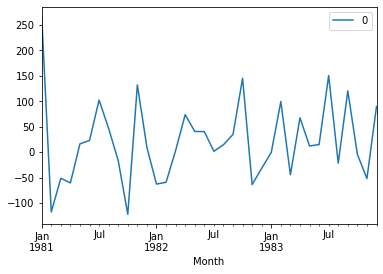

In [17]:
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()


a line plot of the residual errors suggests that there may still be some trend
information not captured by the model.

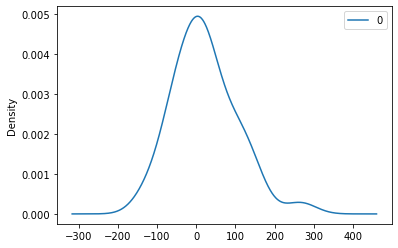

                0
count   36.000000
mean    21.936145
std     80.774430
min   -122.292030
25%    -35.040859
50%     13.147219
75%     68.848286
max    266.000000


In [18]:
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

a density plot of the residual error values suggests the errors are Gaussian, but may not be centered on zero. The results in summary stats show  there is a bias in the prediction (a non-zero mean in the residuals).

## ARIMA Model for Forecasting

> A rolling forecast is required given the dependence on observations in prior time steps for
differencing and the AR model. A crude way to perform this rolling forecast is to re-create the ARIMA model after each new observation is received. We manually keep track of all observations in a list called history that is seeded with the training data and to which new observations are appended each iteration.

In [21]:
# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [22]:
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=343.272180, expected=342.300000
predicted=293.329674, expected=339.700000
predicted=368.668956, expected=440.400000
predicted=335.044741, expected=315.900000
predicted=363.220221, expected=439.300000
predicted=357.645324, expected=401.300000
predicted=443.047835, expected=437.400000
predicted=378.365673, expected=575.500000
predicted=459.415021, expected=407.600000
predicted=526.890876, expected=682.000000
predicted=457.231275, expected=475.300000
predicted=672.914944, expected=581.300000
predicted=531.541449, expected=646.900000


In [23]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 89.021


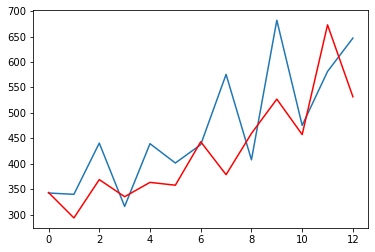

In [24]:
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

The model could use further tuning of the p, d, and maybe even the q parameters. the rolling forecast values show some trend and are in the correct scale.

## GRID Search

we can specify a site of p, d, and q values to search and pass them to the
evaluate models() function. We will try a suite of lag values (p) and just a few difference
iterations (d) and residual error lag values (q).

In [25]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse


In [26]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [28]:
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=228.966
ARIMA(0, 0, 1) RMSE=195.596
ARIMA(0, 0, 2) RMSE=154.886
ARIMA(0, 1, 0) RMSE=133.156
ARIMA(0, 1, 1) RMSE=104.077
ARIMA(0, 1, 2) RMSE=68.345
ARIMA(0, 2, 0) RMSE=255.187
ARIMA(0, 2, 1) RMSE=134.168
ARIMA(0, 2, 2) RMSE=74.644
ARIMA(1, 0, 0) RMSE=152.028
ARIMA(1, 0, 1) RMSE=111.787
ARIMA(1, 0, 2) RMSE=77.083
ARIMA(1, 1, 0) RMSE=88.631
ARIMA(1, 1, 1) RMSE=87.942
ARIMA(1, 1, 2) RMSE=90.986
ARIMA(1, 2, 0) RMSE=134.576
ARIMA(1, 2, 1) RMSE=86.157
ARIMA(1, 2, 2) RMSE=65.511
ARIMA(2, 0, 0) RMSE=100.879
ARIMA(2, 0, 1) RMSE=98.953
ARIMA(2, 0, 2) RMSE=98.690
ARIMA(2, 1, 0) RMSE=85.063
ARIMA(2, 1, 1) RMSE=88.428
ARIMA(2, 1, 2) RMSE=83.496
ARIMA(2, 2, 0) RMSE=97.829
ARIMA(2, 2, 1) RMSE=76.847
ARIMA(2, 2, 2) RMSE=80.808
ARIMA(4, 0, 0) RMSE=100.974
ARIMA(4, 0, 1) RMSE=101.463
ARIMA(4, 0, 2) RMSE=97.574
ARIMA(4, 1, 0) RMSE=95.068
ARIMA(4, 1, 1) RMSE=84.817
ARIMA(4, 1, 2) RMSE=84.204
ARIMA(4, 2, 0) RMSE=85.397
ARIMA(4, 2, 1) RMSE=74.219
ARIMA(4, 2, 2) RMSE=70.141
ARIMA(6, 0, 0) 